In [14]:
# Step 1: Import libraries and preprocess data
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

# Read dataset
data = pd.read_csv("Telco_customer_churn.csv")

# Drop identifier and redundant columns
data = data.drop(columns=['CustomerID', 'Lat Long', 'City', 'State', 'Zip Code'])

# Convert 'Total Charges' to numeric and fill missing
data['Total Charges'] = pd.to_numeric(data['Total Charges'], errors='coerce')
data['Total Charges'] = data['Total Charges'].fillna(data['Total Charges'].median())

# Identify categorical and numerical features
cat_cols = data.select_dtypes(include=['object']).columns.tolist()
num_cols = data.select_dtypes(include=['int64','float64']).columns.tolist()

# Remove target columns from features
target_cols = ['Churn Value', 'Churn Reason','Churn Score','Churn Label']
for t in target_cols:
    if t in num_cols: num_cols.remove(t)
    if t in cat_cols: cat_cols.remove(t)

# Encode categorical variables
le_dict = {}
for col in cat_cols:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    le_dict[col] = le

# Features and target
X = data[cat_cols + num_cols]
y = data['Churn Value']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Preprocessing completed!")
print("Feature shape:", X_train.shape)


Preprocessing completed!
Feature shape: (5634, 24)


In [15]:
# Step 2: Baseline XGBoost model
import xgboost as xgb

baseline_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)
baseline_model.fit(X_train, y_train)

# Predictions and metrics
baseline_pred = baseline_model.predict(X_test)
baseline_pred_prob = baseline_model.predict_proba(X_test)[:,1]

baseline_accuracy = accuracy_score(y_test, baseline_pred)
baseline_precision = precision_score(y_test, baseline_pred)
baseline_recall = recall_score(y_test, baseline_pred)
baseline_f1 = f1_score(y_test, baseline_pred)
baseline_roc_auc = roc_auc_score(y_test, baseline_pred_prob)

print("Baseline Model Performance (Before SHAP-RFS):")
print(f"Accuracy : {baseline_accuracy:.4f}")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall   : {baseline_recall:.4f}")
print(f"F1-Score : {baseline_f1:.4f}")
print(f"ROC-AUC  : {baseline_roc_auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, baseline_pred))


Baseline Model Performance (Before SHAP-RFS):
Accuracy : 0.7857
Precision: 0.6098
Recall   : 0.5348
F1-Score : 0.5698
ROC-AUC  : 0.8411

Confusion Matrix:
[[907 128]
 [174 200]]


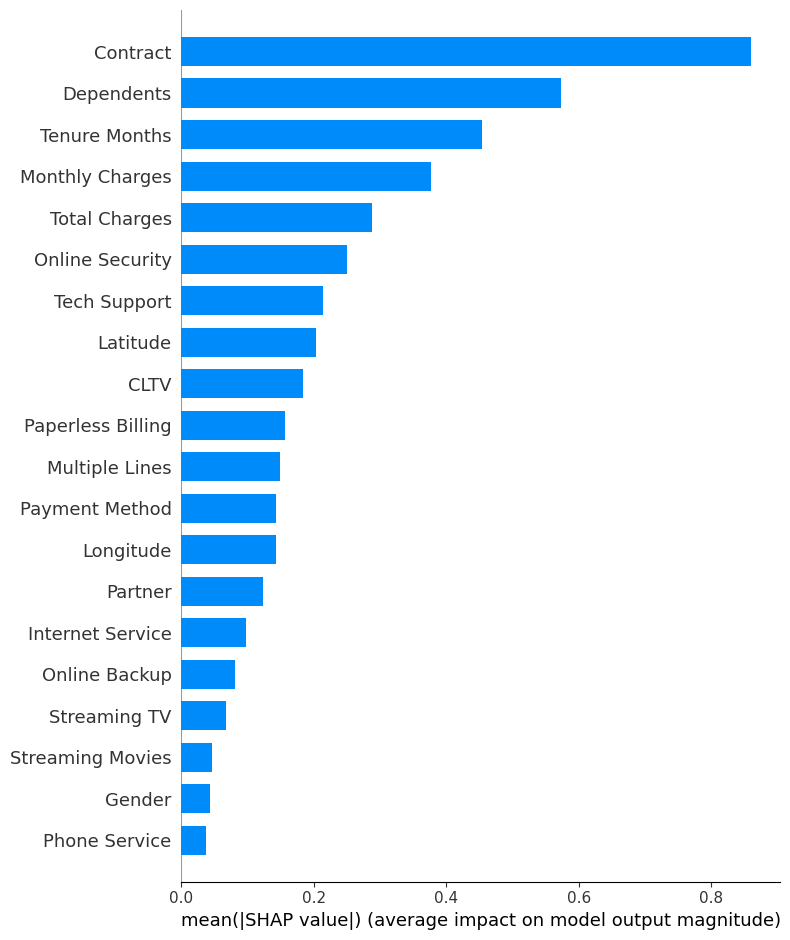

Top features by SHAP importance:
              Feature  SHAP Importance
14           Contract         0.860761
4          Dependents         0.573183
20      Tenure Months         0.453433
21    Monthly Charges         0.376721
22      Total Charges         0.287873
8     Online Security         0.250800
11       Tech Support         0.213643
18           Latitude         0.202997
23               CLTV         0.182976
15  Paperless Billing         0.156241
6      Multiple Lines         0.149012
16     Payment Method         0.143563
19          Longitude         0.143118
3             Partner         0.123022
7    Internet Service         0.098288
9       Online Backup         0.081737
12       Streaming TV         0.067171
13   Streaming Movies         0.046213
1              Gender         0.043216
5       Phone Service         0.037435


In [16]:
# Step 3: Compute SHAP values for initial model
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(baseline_model)
shap_values = explainer.shap_values(X_train)

# Global importance
shap_importance = np.abs(shap_values).mean(axis=0)
feature_importance = pd.DataFrame({
    'Feature': X_train.columns,
    'SHAP Importance': shap_importance
}).sort_values(by='SHAP Importance', ascending=False)

# Plot top 20 features
plt.figure(figsize=(10,6))
shap.summary_plot(shap_values, X_train, plot_type="bar", max_display=20)
plt.show()

print("Top features by SHAP importance:")
print(feature_importance.head(20))


In [ ]:
from copy import deepcopy
import numpy as np
import xgboost as xgb
from sklearn.metrics import roc_auc_score
import shap

X_train_rfs = X_train.copy()
X_test_rfs = X_test.copy()
current_features = X_train.columns.tolist()

min_features = 5
performance_tol = 0.005

best_score = 0
best_features = current_features.copy()
scores = []

iteration = 0
while len(current_features) > min_features:
    iteration += 1
    
    model = xgb.XGBClassifier(
        n_estimators=200,
        max_depth=5,
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='logloss'
    )
    
    model.fit(X_train_rfs[current_features], y_train)
    
    # Evaluate
    y_pred_prob = model.predict_proba(X_test_rfs[current_features])[:,1]
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    scores.append((len(current_features), roc_auc))
    
    if roc_auc >= best_score - performance_tol:
        best_score = roc_auc
        best_features = current_features.copy()
    
    # SHAP values
    explainer = shap.TreeExplainer(model)
    shap_vals = explainer.shap_values(X_train_rfs[current_features])
    
    # Handle multi-class
    if isinstance(shap_vals, list):
        shap_vals = shap_vals[1]
    
    shap_mean = np.abs(shap_vals).mean(axis=0)
    
    # Remove lowest impact feature(s)
    num_to_remove = 1  # or change to remove multiple per iteration
    feat_indices_to_remove = np.argsort(shap_mean)[:num_to_remove]
    features_to_remove = [current_features[i] for i in feat_indices_to_remove]
    
    print(f"Iteration {iteration}: Removing {features_to_remove}, ROC-AUC={roc_auc:.4f}")
    
    for f in features_to_remove:
        current_features.remove(f)

print("\nBest feature subset (SHAP-RFS):")
print(best_features)
print(f"Best ROC-AUC achieved: {best_score:.4f}")


Iteration 1: Removing ['Country'], ROC-AUC=0.8411
Iteration 2: Removing ['Count'], ROC-AUC=0.8417
Iteration 3: Removing ['Senior Citizen'], ROC-AUC=0.8413
Iteration 4: Removing ['Phone Service'], ROC-AUC=0.8391
Iteration 5: Removing ['Device Protection'], ROC-AUC=0.8416
Iteration 6: Removing ['Gender'], ROC-AUC=0.8419
Iteration 7: Removing ['Streaming Movies'], ROC-AUC=0.8432
Iteration 8: Removing ['Online Backup'], ROC-AUC=0.8397
Iteration 9: Removing ['Streaming TV'], ROC-AUC=0.8414
Iteration 10: Removing ['Internet Service'], ROC-AUC=0.8420
Iteration 11: Removing ['Partner'], ROC-AUC=0.8387
Iteration 12: Removing ['Paperless Billing'], ROC-AUC=0.8360
Iteration 13: Removing ['Longitude'], ROC-AUC=0.8361


Final Model Performance (After SHAP-RFS):
Accuracy : 0.7999
Precision: 0.6474
Recall   : 0.5401
F1-Score : 0.5889
ROC-AUC  : 0.8394

Confusion Matrix:
[[925 110]
 [172 202]]
SHAP values shape: (5634, 6)
Training data shape: (5634, 6)


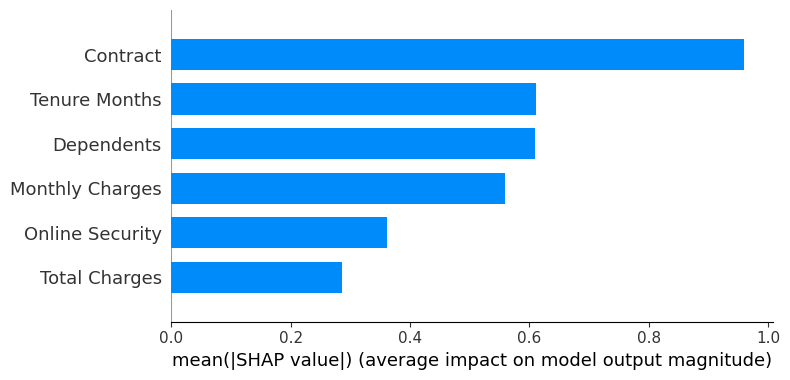

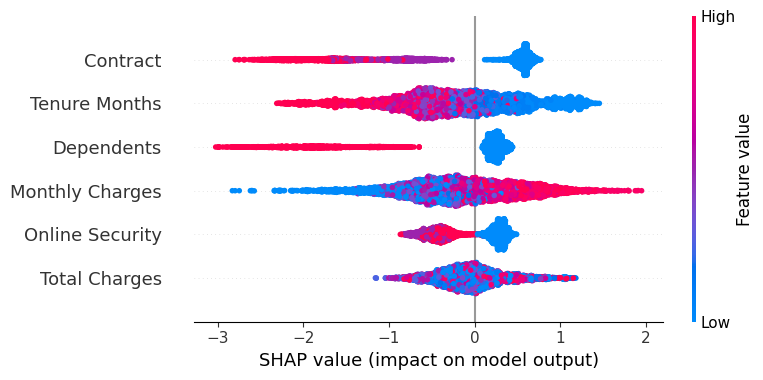

In [13]:
# -------------------------------
# Step 5: Train final model on best feature subset
# -------------------------------
final_X_train = X_train_rfs[best_features]
final_X_test = X_test_rfs[best_features]

final_model = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    eval_metric='logloss'
)

# Train the model
final_model.fit(final_X_train, y_train)

# -------------------------------
# Step 6: Predictions & performance metrics
# -------------------------------
final_pred = final_model.predict(final_X_test)
final_pred_prob = final_model.predict_proba(final_X_test)[:,1]  # for ROC-AUC

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

final_accuracy = accuracy_score(y_test, final_pred)
final_precision = precision_score(y_test, final_pred)
final_recall = recall_score(y_test, final_pred)
final_f1 = f1_score(y_test, final_pred)
final_roc_auc = roc_auc_score(y_test, final_pred_prob)

print("Final Model Performance (After SHAP-RFS):")
print(f"Accuracy : {final_accuracy:.4f}")
print(f"Precision: {final_precision:.4f}")
print(f"Recall   : {final_recall:.4f}")
print(f"F1-Score : {final_f1:.4f}")
print(f"ROC-AUC  : {final_roc_auc:.4f}")

print("\nConfusion Matrix:")
print(confusion_matrix(y_test, final_pred))

# -------------------------------
# Step 7: Compute SHAP values
# -------------------------------
#-------------------------------
# Step 7: Compute SHAP values (fixed)
# -------------------------------
import shap
import matplotlib.pyplot as plt

explainer = shap.TreeExplainer(final_model)

# Use the call interface instead of .shap_values
shap_exp = explainer(final_X_train)

# Extract the SHAP values matrix
shap_values = shap_exp.values  # shape: (n_samples, n_features)

# For multi-class classifiers, shap_values may be 3D
if shap_values.ndim == 3:
    # Take the positive class (usually class 1)
    shap_values = shap_values[:, :, 1]

# Now shap_values has the same number of features as final_X_train
print("SHAP values shape:", shap_values.shape)
print("Training data shape:", final_X_train.shape)

# -------------------------------
# Step 8: SHAP summary plots
# -------------------------------
# Bar plot
shap.summary_plot(shap_values, final_X_train, plot_type="bar", max_display=20)

# Beeswarm plot
shap.summary_plot(shap_values, final_X_train, plot_type="dot", max_display=20)

